**Импорт необходимых библиотек**

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from pprint import pprint
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

**Импорт данных**

In [3]:
data = pd.read_csv('Admission_Predict.csv')

**Общая информация о данных**

In [4]:
data

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...,...
395,396,324,110,3,3.5,3.5,9.04,1,0.82
396,397,325,107,3,3.0,3.5,9.11,1,0.84
397,398,330,116,4,5.0,4.5,9.45,1,0.91
398,399,312,103,3,3.5,4.0,8.78,0,0.67


Данная задача является регрессией, поскольку целевая переменная Chance of Admit представляет собой непрерывное числовое значение.

Кол-во строк 400 и столбцов: 9
Целевая переменная: Chance of Admit 
Кол-во уникальных значений целевой переменной: 60


<Axes: >

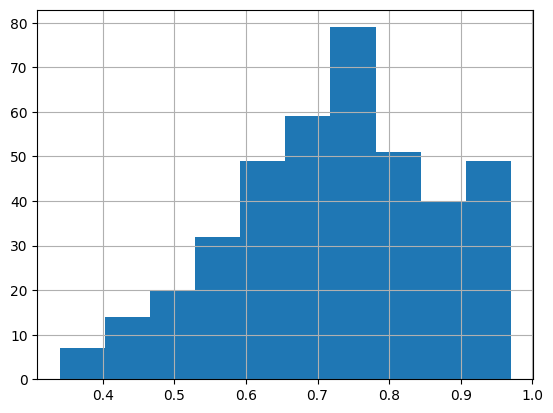

In [5]:
print(f'Кол-во строк {data.shape[0]} и столбцов: {data.shape[1]}')
target_variable = 'Chance of Admit '
print(f'Целевая переменная: {target_variable}')
print(f'Кол-во уникальных значений целевой переменной: {data[target_variable].nunique()}')
data[target_variable].hist()

In [6]:
print('Кол-во пропусов в колонках: ')
data.isnull().sum()

Кол-во пропусов в колонках: 


,0
Serial No.,0
GRE Score,0
TOEFL Score,0
University Rating,0
SOP,0
LOR,0
CGPA,0
Research,0
Chance of Admit,0


In [ ]:
print('Общая информация о датасете')
data[target_variable].describe()

Общая информация о датасете


,Chance of Admit
count,400.000000
mean,0.724350
std,0.142609
min,0.340000
25%,0.640000
50%,0.730000
75%,0.830000
max,0.970000


**Предобработка данных**

1. Нормированные численных переменных

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

y = data[target_variable]
X = data.drop(columns=[target_variable], axis=1)
X = X.drop('Serial No.', axis=1)

X_ans = StandardScaler().fit_transform(X)

In [9]:
X_ans

array([[ 1.76210664,  1.74697064,  0.79882862, ...,  1.16732114,
         1.76481828,  0.90911166],
       [ 0.62765641, -0.06763531,  0.79882862, ...,  1.16732114,
         0.45515126,  0.90911166],
       [-0.07046681, -0.56252785, -0.07660001, ...,  0.05293342,
        -1.00563118,  0.90911166],
       ...,
       [ 1.15124883,  1.41704229,  0.79882862, ...,  1.16732114,
         1.42900622,  0.90911166],
       [-0.41952842, -0.72749202, -0.07660001, ...,  0.61012728,
         0.30403584, -1.09997489],
       [ 1.41304503,  1.58200646,  0.79882862, ...,  0.61012728,
         1.78160888,  0.90911166]])

2. Разделение данных на тренировочную и тестовую выборки

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =  train_test_split(X_ans, y, test_size=0.2, random_state=42)

**Оформление данных в виде класса Dataset из библиотеки torch**

In [27]:
train_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test.values, dtype=torch.float32)
    ),
    batch_size=32,
    shuffle=True
)

test_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train.values, dtype=torch.float32)
    ),
    batch_size=32,
    shuffle=False
)

Выводим получившиеся датасеты

In [28]:
for batch, (inputs, targets) in enumerate(trainLoader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {inputs.shape}")
    print(f"y shape: {targets.shape}")
    break

Batch: 1
X shape: torch.Size([32, 7])
y shape: torch.Size([32])


**Обучение на тренировочном множестве**

In [32]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc = nn.Linear(7, 1)

    def forward(self, x):
        return self.fc(x)

class HiddenLayerNN(nn.Module):
    def __init__(self):
        super(HiddenLayerNN, self).__init__()
        self.fc1 = nn.Linear(7, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class ComplexNN(nn.Module):
    def __init__(self):
        super(ComplexNN, self).__init__()
        self.fc1 = nn.Linear(7, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 5)
        self.fc4 = nn.Linear(5, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)



def train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, epochs=100):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        epoch_test_loss = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.view(-1), targets)
                epoch_test_loss += loss.item()

        avg_test_loss = epoch_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

    return train_losses, test_losses

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Используется устройство: {device}")


model1 = SimpleNN().to(device)
criterion = nn.MSELoss()
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.01)
train_losses_model1, test_losses_model1 = train_and_evaluate_model(model1, train_loader, test_loader, criterion, optimizer1)

print()

model2 = HiddenLayerNN().to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)
train_losses_model2, test_losses_model2 = train_and_evaluate_model(model2, train_loader, test_loader, criterion, optimizer2)

print()

model3 = ComplexNN().to(device)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.001)
train_losses_model3, test_losses_model3 = train_and_evaluate_model(model3, train_loader, test_loader, criterion, optimizer3)

Используется устройство: cpu
Epoch 1/100, Train Loss: 1.2934, Test Loss: 1.1191
Epoch 2/100, Train Loss: 1.0520, Test Loss: 0.9642
Epoch 3/100, Train Loss: 0.9460, Test Loss: 0.8357
Epoch 4/100, Train Loss: 0.7773, Test Loss: 0.7390
Epoch 5/100, Train Loss: 0.7257, Test Loss: 0.6552
Epoch 6/100, Train Loss: 0.6396, Test Loss: 0.5775
Epoch 7/100, Train Loss: 0.5612, Test Loss: 0.5139
Epoch 8/100, Train Loss: 0.4915, Test Loss: 0.4578
Epoch 9/100, Train Loss: 0.4376, Test Loss: 0.4069
Epoch 10/100, Train Loss: 0.4081, Test Loss: 0.3617
Epoch 11/100, Train Loss: 0.3449, Test Loss: 0.3236
Epoch 12/100, Train Loss: 0.3280, Test Loss: 0.2869
Epoch 13/100, Train Loss: 0.2729, Test Loss: 0.2570
Epoch 14/100, Train Loss: 0.2551, Test Loss: 0.2286
Epoch 15/100, Train Loss: 0.2208, Test Loss: 0.2050
Epoch 16/100, Train Loss: 0.1855, Test Loss: 0.1849
Epoch 17/100, Train Loss: 0.1841, Test Loss: 0.1660
Epoch 18/100, Train Loss: 0.1529, Test Loss: 0.1500
Epoch 19/100, Train Loss: 0.1406, Test Loss:

**Визуализация кривых обучения**

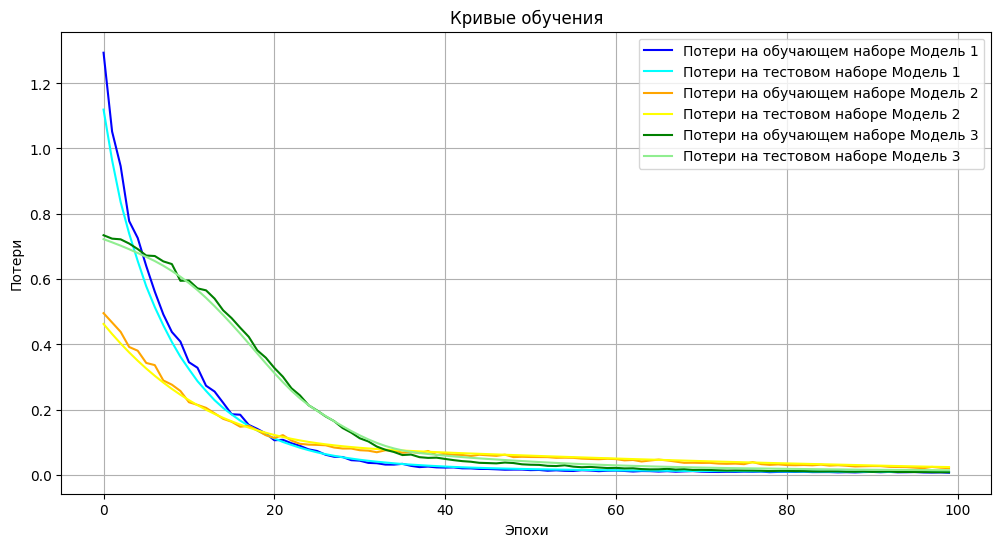

In [34]:
plt.figure(figsize=(12, 6))

plt.plot(train_losses_model1, label='Потери на обучающем наборе Модель 1', color='blue')
plt.plot(test_losses_model1, label='Потери на тестовом наборе Модель 1', color='cyan')

plt.plot(train_losses_model2, label='Потери на обучающем наборе Модель 2', color='orange')
plt.plot(test_losses_model2, label='Потери на тестовом наборе Модель 2', color='yellow')

plt.plot(train_losses_model3, label='Потери на обучающем наборе Модель 3', color='green')
plt.plot(test_losses_model3, label='Потери на тестовом наборе Модель 3', color='lightgreen')

plt.title('Кривые обучения')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.grid()
plt.show()

**Метрики оценки моделей**

In [35]:
def calculate_mae(model, data_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu().numpy()
            y_true.extend(targets.numpy())
            y_pred.extend(outputs.flatten())

    return mean_absolute_error(y_true, y_pred)

mae_train_model1 = calculate_mae(model1, train_loader)
mae_test_model1 = calculate_mae(model1, test_loader)

mae_train_model2 = calculate_mae(model2, train_loader)
mae_test_model2 = calculate_mae(model2, test_loader)

mae_train_model3 = calculate_mae(model3, train_loader)
mae_test_model3 = calculate_mae(model3, test_loader)

print(f'MAE на обучающем наборе Модель 1: {mae_train_model1:.4f}, MAE на тестовом наборе Модель 1: {mae_test_model1:.4f}')
print(f'MAE на обучающем наборе Модель 2: {mae_train_model2:.4f}, MAE на тестовом наборе Модель 2: {mae_test_model2:.4f}')
print(f'MAE на обучающем наборе Модель 3: {mae_train_model3:.4f}, MAE на тестовом наборе Модель 3: {mae_test_model3:.4f}')

MAE на обучающем наборе Модель 1: 0.0596, MAE на тестовом наборе Модель 1: 0.0720
MAE на обучающем наборе Модель 2: 0.1166, MAE на тестовом наборе Модель 2: 0.1222
MAE на обучающем наборе Модель 3: 0.0726, MAE на тестовом наборе Модель 3: 0.0964
